In [12]:
import tqdm
import torch
import gpytorch
import numpy as np
from matplotlib import pyplot as plt
import time

from matplotlib import style
style.use('seaborn-white')

from numpy import genfromtxt
#gpytorch.settings.max_cg_iterations(2000)

from torch.utils.data import TensorDataset, DataLoader

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/mnt/bgfs/belal/4240961/ipykernel_881/4105414838.py:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  style.use('seaborn-white')


In [13]:
def cartPoleDyn(theta, theta_d, x, x_d, m1, m2, length, k_inertia, mu_c, mu_p, gravity, force, dt):
    theta_dd = ((m1+m2)*gravity*np.sin(theta)-np.cos(theta)*(force+m2*length*(theta_d**2)*np.sin(theta)-mu_c*x_d)-((m1+m2)*mu_p*theta_d)/(m2*length)) / ((m1+m2)*(k_inertia+1)*length - m2*length*(np.cos(theta))**2)
    x_dd = (force-m2*length*(theta_dd*np.cos(theta)-(theta_d**2)*np.sin(theta))-mu_c*x_d) / (m1+m2)
    # Euler Integrator 
    x_d = x_d + x_dd*dt
    x = x + x_d*dt
    theta_d = theta_d + theta_dd*dt
    theta = theta + theta_d*dt
    return theta_dd, theta_d, theta, x_dd, x_d,  x 

In [14]:
# Uncertainty Sources 
m1 = 1 
m2 = 0.1
length = 0.5
k_inertia = 1/3
mu_c = 0.0005
mu_p = 0.000002
gravity = 9.8 
dt = 0.01

# Initialization 
theta = 0.3 # np.random.uniform(low=-0.05, high=0.05)
theta_d = 1 # np.random.uniform(low=-0.05, high=0.05)
x = 0 # np.random.uniform(low=-0.05, high=0.05)
x_d = 0 # np.random.uniform(low=-0.05, high=0.05)

# lists for storing results 
theta_dd_sim = []           # theta double derivative 
theta_d_sim = [theta_d]     # theta derivative 
theta_sim = [theta]         # theta  
x_dd_sim = []               # x double derivative 
x_d_sim = [x_d]             # x derivative 
x_sim = [x]                 # x

noOfSteps = 16000
ts = np.linspace(0, noOfSteps/(1/dt), num=noOfSteps, endpoint=False)

for i in range(noOfSteps):
    force = 0.5*np.sin(6*ts[i]) #-0.2+
    #force = -1+np.sin(ts[i])+3*np.sin(2*ts[i])
    #force = -0.5+0.2*np.sin(ts[i])+0.3*np.sin(2*ts[i])
    theta_dd, theta_d, theta, x_dd, x_d, x = cartPoleDyn(theta, theta_d, x, x_d, m1, m2, length, k_inertia, mu_c, mu_p, gravity, force, dt)
    theta_dd_sim.append(theta_dd)
    theta_d_sim.append(theta_d)
    theta_sim.append(theta)
    x_dd_sim.append(x_dd)
    x_d_sim.append(x_d)
    x_sim.append(x)

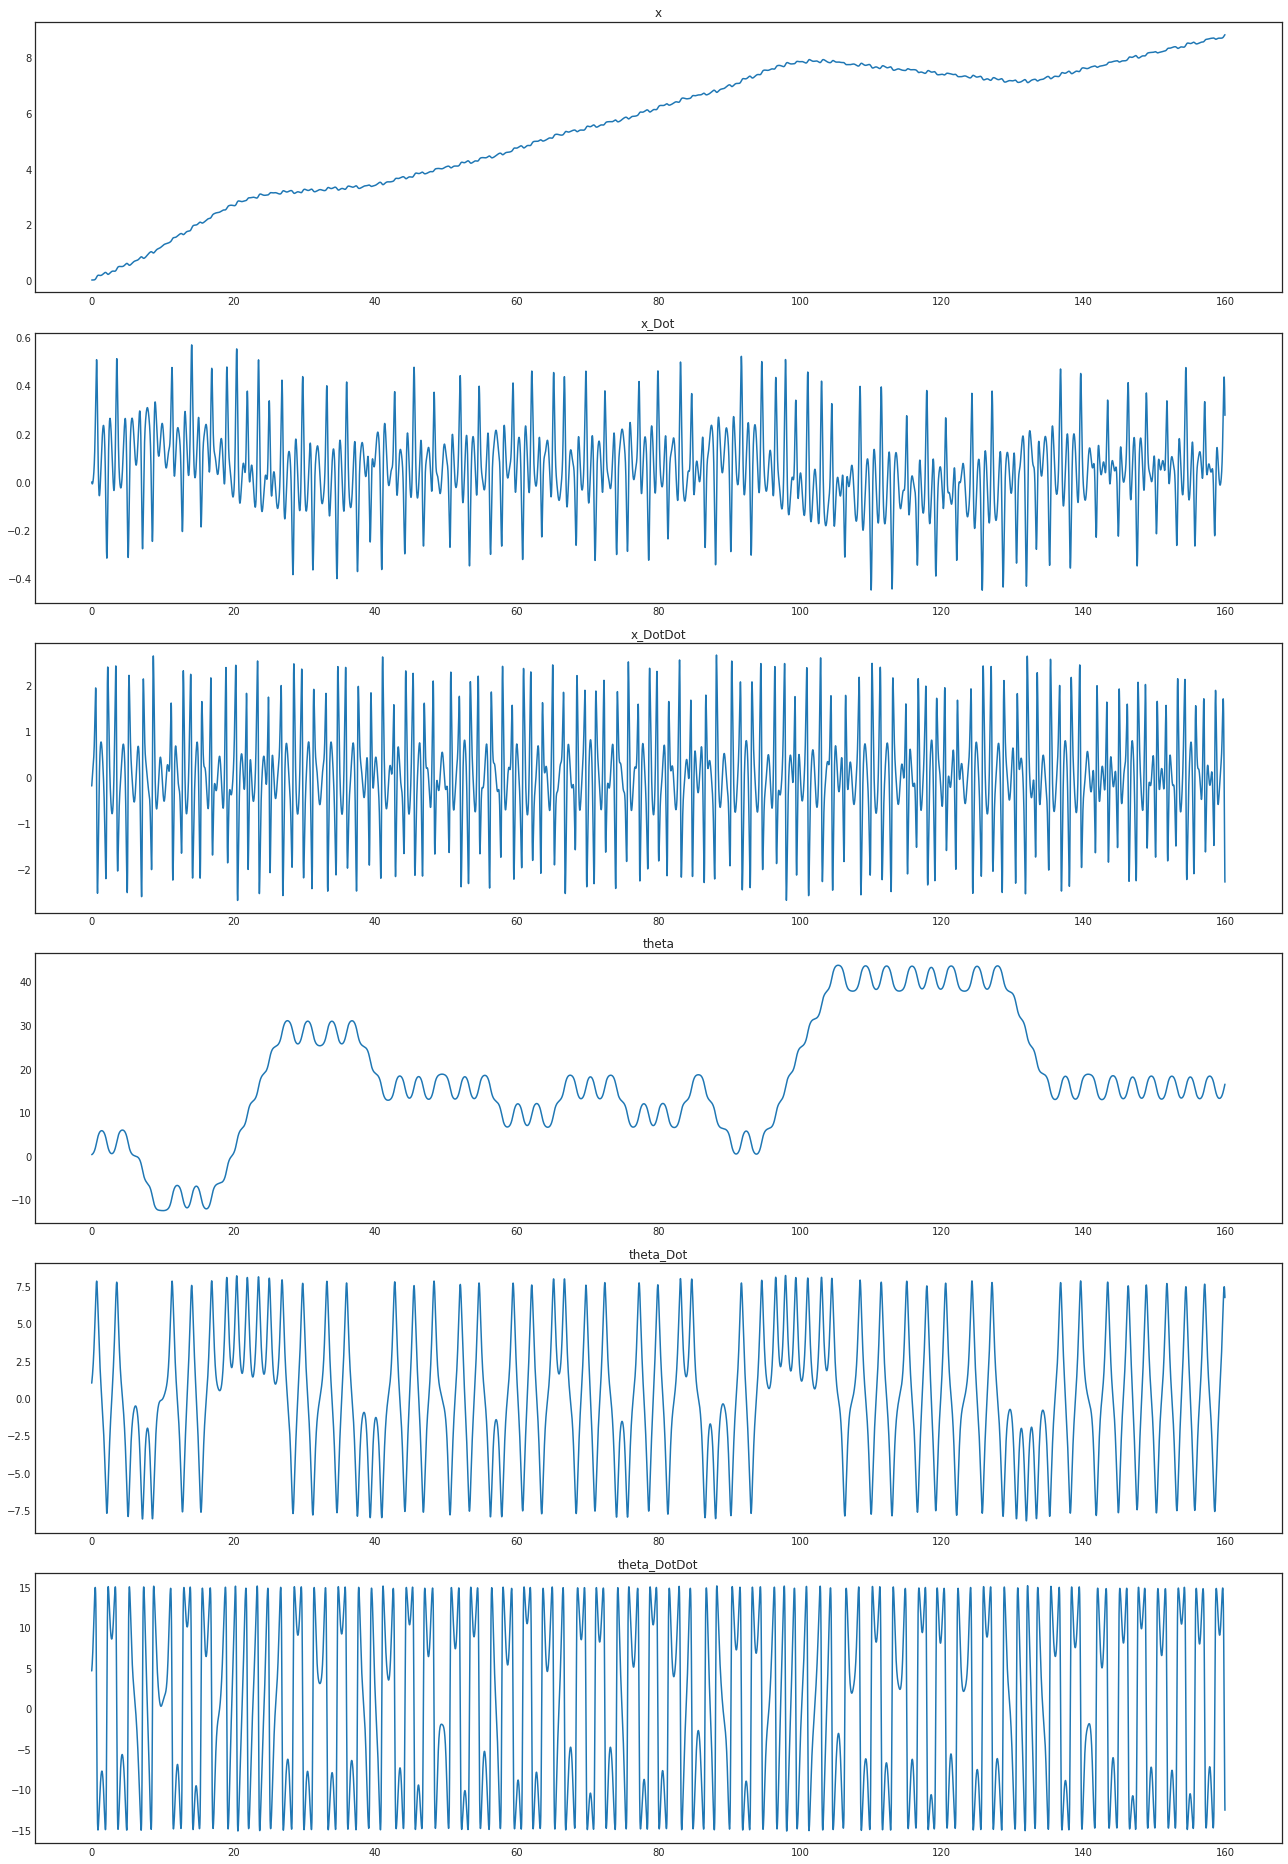

In [15]:
# Converting to Numpy Arrays for Plotting
theta_dd_sim = np.array(theta_dd_sim)
theta_d_sim = np.array(theta_d_sim)
theta_sim = np.array(theta_sim)
x_dd_sim = np.array(x_dd_sim)
x_d_sim = np.array(x_d_sim)
x_sim = np.array(x_sim)

dt = 0.01
noOfSteps = 16000
timeSteps = np.linspace(0, noOfSteps/(1/dt), num=noOfSteps, endpoint=False) # for plotting 

timeSteps = np.linspace(0, noOfSteps/(1/dt), num=noOfSteps, endpoint=False)

startTraj = 0
endTraj = 16000

# Plotting 
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6)

fig.set_figheight(26)
fig.set_figwidth(18)

ax1.plot(timeSteps[startTraj:endTraj], x_sim[startTraj:endTraj])
ax1.set_title("x")
ax2.plot(timeSteps[startTraj:endTraj], x_d_sim[startTraj:endTraj])
ax2.set_title("x_Dot")
ax3.plot(timeSteps[startTraj:endTraj], x_dd_sim[startTraj:endTraj])
ax3.set_title("x_DotDot")
#axs[1, 0].sharex(axs[0, 0])
ax4.plot(timeSteps[startTraj:endTraj], theta_sim[startTraj:endTraj])
ax4.set_title("theta")
ax5.plot(timeSteps[startTraj:endTraj], theta_d_sim[startTraj:endTraj])
ax5.set_title("theta_Dot")
ax6.plot(timeSteps[startTraj:endTraj], theta_dd_sim[startTraj:endTraj])
ax6.set_title("theta_DotDot")
fig.tight_layout()

Text(0.5, 1.0, 'A single plot')

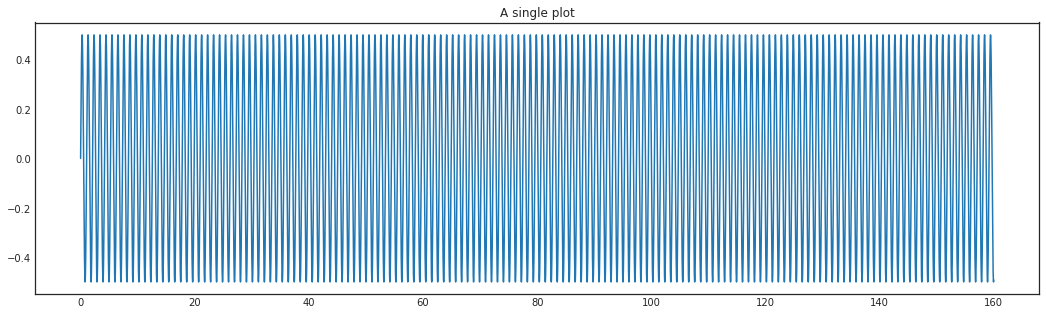

In [16]:
# Force Input Plot 
forceIn = 0.5*np.sin(6*timeSteps) #-0.2+
fig, ax = plt.subplots()

fig.set_figheight(5)
fig.set_figwidth(18)

ax.plot(timeSteps[startTraj:endTraj], forceIn[startTraj:endTraj])
ax.set_title('A single plot')

In [17]:
st_Traj = 0
en_Traj = 12000 # 2307 # 9405

# Training Input (Standardized)
theta_sim_mean = theta_sim[st_Traj:en_Traj].mean()
theta_sim_stdev = theta_sim[st_Traj:en_Traj].std()

theta_d_sim_mean = theta_d_sim[st_Traj:en_Traj].mean()
theta_d_sim_stdev = theta_d_sim[st_Traj:en_Traj].std()

x_d_sim_mean = x_d_sim[st_Traj:en_Traj].mean()
x_d_sim_stdev = x_d_sim[st_Traj:en_Traj].std()

forceIn_mean = forceIn[st_Traj:en_Traj].mean()
forceIn_stdev = forceIn[st_Traj:en_Traj].std()  

# Training Output (Standardized)
theta_dd_sim_mean = theta_dd_sim[st_Traj:en_Traj].mean()
theta_dd_sim_stdev = theta_dd_sim[st_Traj:en_Traj].std()  

x_dd_sim_mean = x_dd_sim[st_Traj:en_Traj].mean()
x_dd_sim_stdev = x_dd_sim[st_Traj:en_Traj].std() 

X_train = np.stack(((theta_sim[st_Traj:en_Traj]-theta_sim_mean)/theta_sim_stdev,(theta_d_sim[st_Traj:en_Traj]-theta_d_sim_mean)/theta_d_sim_stdev,(x_d_sim[st_Traj:en_Traj]-x_d_sim_mean)/x_d_sim_stdev,(forceIn[st_Traj:en_Traj]-forceIn_mean)/forceIn_stdev), axis=1)

Y_train_theta = ((theta_dd_sim[st_Traj:en_Traj]-theta_dd_sim_mean)/theta_dd_sim_stdev)  # RMSE(A)
Y_train_x = ((x_dd_sim[st_Traj:en_Traj]-x_dd_sim_mean)/x_dd_sim_stdev)  # RMSE(V)

# Testing Output (Standardized)

Y_test_theta = ((theta_dd_sim[en_Traj:]-theta_dd_sim_mean)/theta_dd_sim_stdev)  # RMSE(A)
Y_test_x = ((x_dd_sim[en_Traj:]-x_dd_sim_mean)/x_dd_sim_stdev)  # RMSE(V)

Y_theta = ((theta_dd_sim-theta_dd_sim_mean)/theta_dd_sim_stdev)
Y_x = ((x_dd_sim-x_dd_sim_mean)/x_dd_sim_stdev)
X_prior = np.stack(((theta_sim[:-1]-theta_sim_mean)/theta_sim_stdev,(theta_d_sim[:-1]-theta_d_sim_mean)/theta_d_sim_stdev,(x_d_sim[:-1]-x_d_sim_mean)/x_d_sim_stdev,(forceIn-forceIn_mean)/forceIn_stdev), axis=1) # Prior

In [18]:
# Numpy to tensors 
X_train = torch.from_numpy(X_train).float()
Y_train_theta = torch.from_numpy(Y_train_theta).float()
Y_train_x = torch.from_numpy(Y_train_x).float()
X_prior = torch.from_numpy(X_prior).float()
Y_theta = torch.from_numpy(Y_theta).float()
Y_x = torch.from_numpy(Y_x).float()

# Putting tensors on GPU
if torch.cuda.is_available():
    X_train, Y_train_theta, Y_train_x, X_prior, Y_theta, Y_x = X_train.cuda(), Y_train_theta.cuda(), Y_train_x.cuda(), X_prior.cuda(), Y_theta.cuda(), Y_x.cuda()

In [19]:
train_dataset = TensorDataset(X_train, Y_train_theta)
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)

test_dataset = TensorDataset(X_prior, Y_theta)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False)

In [20]:
class StandardApproximateGP(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points):
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(inducing_points.size(0))
        variational_strategy = gpytorch.variational.VariationalStrategy(self, inducing_points, variational_distribution, learn_inducing_locations=True)
        super().__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=4))

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

#indPts = np.sort(np.random.randint(low=0, high=8000, size=(500,)))
#inducing_points = X_train[indPts,:]
inducing_points = X_train
#inducing_points = torch.randn(4000, X_train.size(-1), dtype=X_train.dtype, device=X_train.device)
model = StandardApproximateGP(inducing_points=inducing_points)
likelihood = gpytorch.likelihoods.GaussianLikelihood()

if torch.cuda.is_available():
    model = model.cuda()
    likelihood = likelihood.cuda()

In [ ]:
model.train()
likelihood.train()

optimizer = torch.optim.Adam([
    {'params': model.parameters()},
    {'params': likelihood.parameters()},
], lr=0.001)

# Our loss object. We're using the VariationalELBO
mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=Y_train_theta.size(0))

start_time = time.time()
losses = []
num_epochs = 1000
epochs_iter = tqdm.notebook.tqdm(range(num_epochs), desc="Epoch")
for i in epochs_iter:
    # Within each iteration, we will go over each minibatch of data
    minibatch_iter = tqdm.notebook.tqdm(train_loader, desc="Minibatch", leave=False, disable=True)
    for x_batch, y_batch in minibatch_iter:
        optimizer.zero_grad()
        output = model(x_batch)
        loss = -mll(output, y_batch)
        minibatch_iter.set_postfix(loss=loss.item())
        losses.append(loss.detach().cpu().numpy())
        loss.backward()
        optimizer.step()
    if i%100==0:
        #print('Loss: %.3f' % (loss.item())) 
        print('Iter %d/%d - Loss: %.3f  noise: %.3f' % (
        i , num_epochs, loss.item(),
        likelihood.noise.item()
    ))
 
print('Total time is %s:' %(time.time() - start_time)) 

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Iter 0/1000 - Loss: 1.649  noise: 0.699
Iter 100/1000 - Loss: 0.533  noise: 0.308
Iter 200/1000 - Loss: -0.290  noise: 0.071
Iter 300/1000 - Loss: -0.932  noise: 0.020
Iter 400/1000 - Loss: -1.508  noise: 0.006
Iter 500/1000 - Loss: -2.011  noise: 0.002
Iter 600/1000 - Loss: -2.371  noise: 0.001
Iter 700/1000 - Loss: -2.637  noise: 0.000
Iter 800/1000 - Loss: -2.757  noise: 0.000
Iter 900/1000 - Loss: -2.815  noise: 0.000


In [ ]:
torch.save(model.state_dict(), '../../learnedModels/deterministicCase/SVGPwithGPyTorch/SVGP(Train1k)(12kInd)ForceIn(ARD)')  

In [21]:
model.load_state_dict(torch.load('../../learnedModels/deterministicCase/SVGPwithGPyTorch/SVGP(Train1k)(12kInd)ForceIn(ARD)'))

model.eval()
likelihood.eval() 

means = np.zeros(X_prior.shape[0])
lowers = np.zeros(X_prior.shape[0])
uppers = np.zeros(X_prior.shape[0])

with torch.no_grad():
    i = 0
    #for x_batch, y_batch in test_loader:
    preds = model(X_prior)
    lower, upper = preds.confidence_region()
    means = preds.mean.cpu().numpy()
    lowers = lower.cpu().numpy()
    uppers = upper.cpu().numpy()

In [22]:
allData = np.stack((means, lowers, uppers, Y_theta.cpu()), axis=1)
np.savetxt('../../../Results/deterministicCase/SVGPwithGPyTorch/SVGP(Train1k)(12kInd)ForceIn(ARD).csv', allData, delimiter=',')

In [13]:
model.eval()
likelihood.eval()
means = torch.tensor([0.])
lowers = torch.tensor([0.])
uppers = torch.tensor([0.])

with torch.no_grad():
    for x_batch, y_batch in test_loader:
        preds = model(x_batch)
        lower, upper = preds.confidence_region()
        means = torch.cat([means, preds.mean.cpu()])
        lowers = torch.cat([lowers, lower.cpu()])
        uppers = torch.cat([uppers, upper.cpu()]) 

means = means[1:]
lowers = lowers[1:]
uppers = uppers[1:]

In [23]:
# loading prediction data from csv
means = np.zeros((12000,))
lowers = np.zeros((12000,))
uppers = np.zeros((12000,))
Y_theta = np.zeros((12000,))

my_data = genfromtxt('../../../Results/deterministicCase/SVGPwithGPyTorch/SVGP(Train1k)(12kInd)ForceIn(ARD).csv', delimiter=',')
means = my_data[:,0]
lowers = my_data[:,1]
uppers = my_data[:,2]
Y_theta = my_data[:,3]

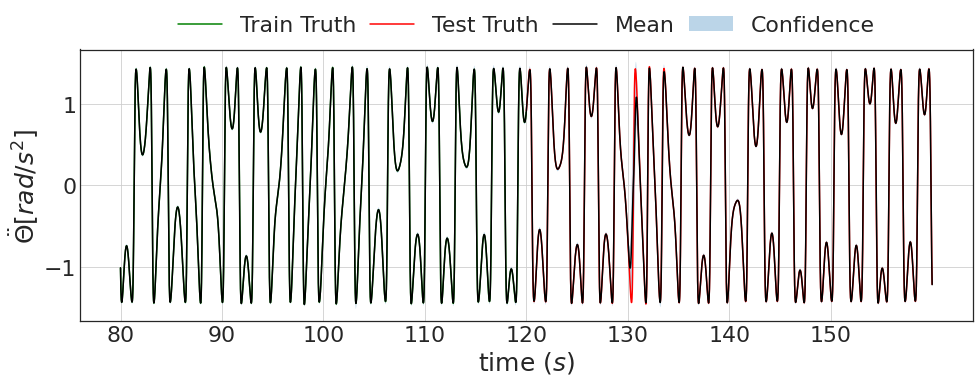

In [30]:
start_traj = 8000
en_Traj = 12000
end_traj = 16000

fig = plt.figure() 

gs = fig.add_gridspec(1)
ax = gs.subplots(sharex=True)

fig.set_figheight(5)
fig.set_figwidth(16)

plt.rc('font', size=22)          # controls default text sizes
plt.rc('axes', titlesize=22)     # fontsize of the axes title
plt.rc('axes', labelsize=25)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=22)    # fontsize of the tick labels
plt.rc('ytick', labelsize=22)    # fontsize of the tick labels
plt.rc('legend', fontsize=22)    # legend fontsize
plt.rc('figure', titlesize=12)  # fontsize of the figure title

ax.plot(timeSteps[start_traj:en_Traj], Y_theta[start_traj:en_Traj], c='g')
ax.plot(timeSteps[en_Traj:end_traj], Y_theta[en_Traj:end_traj], c='r')
ax.plot(timeSteps[start_traj:end_traj], means[start_traj:end_traj], c='k')
ax.fill_between(timeSteps[start_traj:end_traj], lowers[start_traj:end_traj], uppers[start_traj:end_traj], alpha=0.3)
ax.set_ylabel(r"$\ddot{\Theta}[rad/s^2]$")
ax.grid(True)
ax.xaxis.set_ticks(np.arange(min(timeSteps[start_traj:end_traj]), max(timeSteps[start_traj:end_traj]), 10))
ax.legend(('Train Truth', 'Test Truth', 'Mean', 'Confidence'), bbox_to_anchor=(0.1,1.02,0.8,0.2), mode='expand', loc='lower left', ncol=4, borderaxespad=0, shadow=False)
ax.set_xlabel('time $(s)$')
#plt.savefig('../../../Results/deterministicCase/SVGPwithGPyTorch/SVGP(Train1k)(12kInd)ForceIn(ARD).png')

In [ ]:
losses = np.array(losses)
plot_loss = np.linspace(0, losses.shape[0], num=losses.shape[0], endpoint=False)

fig, ax = plt.subplots(1)

fig.set_figheight(5)
fig.set_figwidth(16)

ax.plot(plot_loss, losses, 'k')
plt.show()

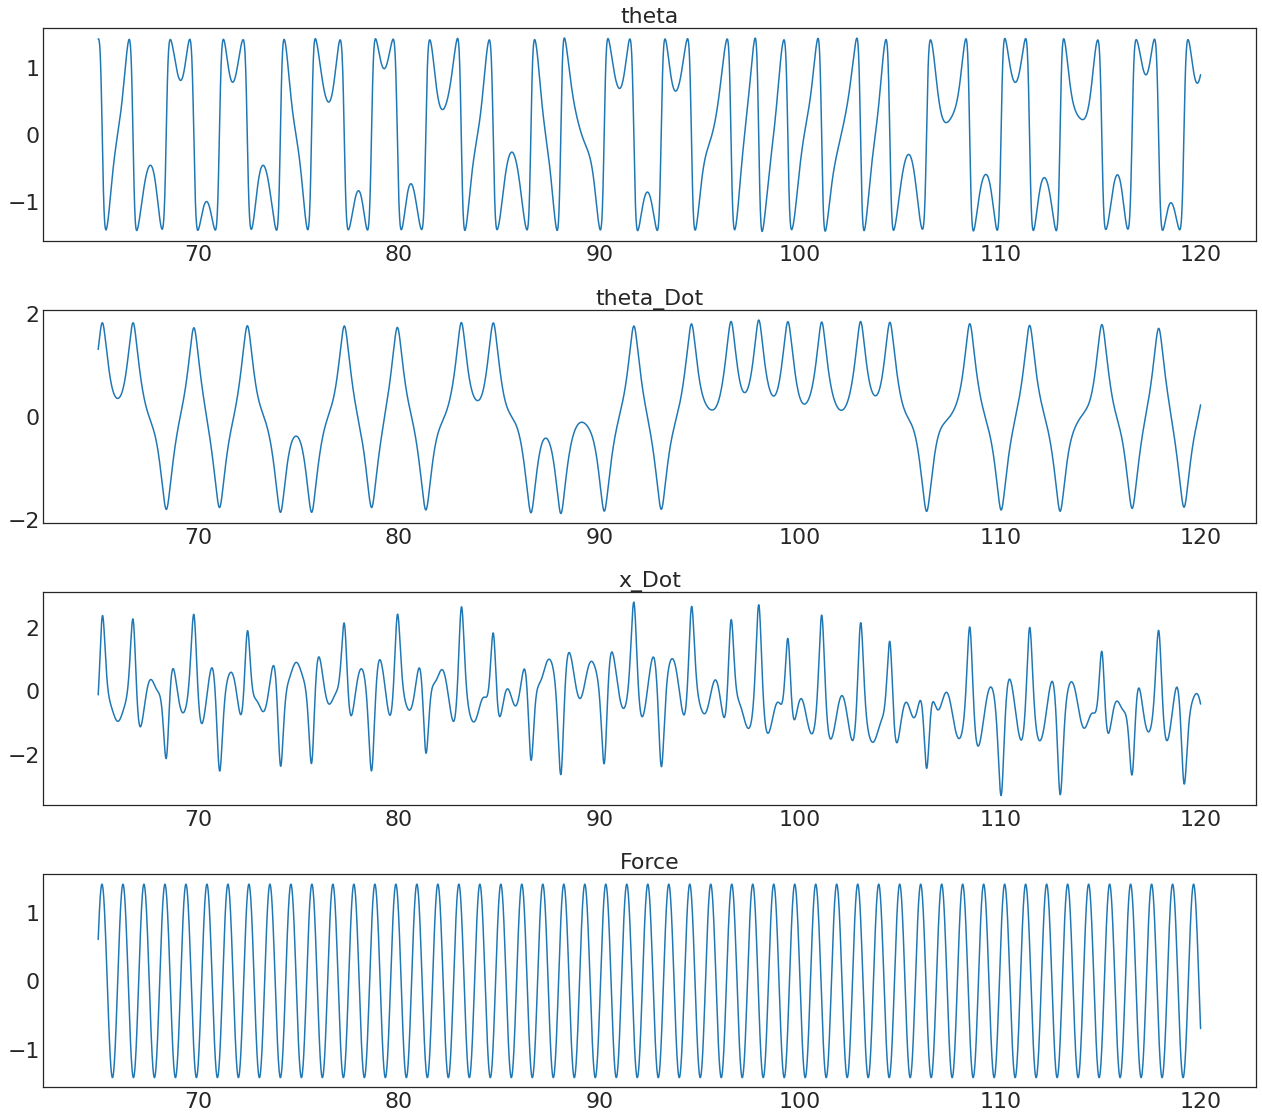

In [38]:
startTraj = 6500
endTraj = 12000

# Plotting 
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4)

fig.set_figheight(16)
fig.set_figwidth(18)

ax1.plot(timeSteps[startTraj:endTraj], Y_theta[startTraj:endTraj])
ax1.set_title("theta")
ax2.plot(timeSteps[startTraj:endTraj], X_prior[startTraj:endTraj,1].cpu().numpy())
ax2.set_title("theta_Dot")
ax3.plot(timeSteps[startTraj:endTraj], X_prior[startTraj:endTraj,2].cpu().numpy())
ax3.set_title("x_Dot")
ax4.plot(timeSteps[startTraj:endTraj], X_prior[startTraj:endTraj,3].cpu().numpy())
ax4.set_title("Force")
fig.tight_layout()

In [50]:
means?

Type:        ndarray
String form:
[ 0.43492967  0.43987256  0.45266515 ... -0.03577982 -0.03776276
 -0.03980796]
Length:      12000
File:        /work/flemingc/belal/anaconda3/envs/gpytorch/lib/python3.8/site-packages/numpy/__init__.py
Docstring:  
ndarray(shape, dtype=float, buffer=None, offset=0,
        strides=None, order=None)

An array object represents a multidimensional, homogeneous array
of fixed-size items.  An associated data-type object describes the
format of each element in the array (its byte-order, how many bytes it
occupies in memory, whether it is an integer, a floating point number,
or something else, etc.)

Arrays should be constructed using `array`, `zeros` or `empty` (refer
to the See Also section below).  The parameters given here refer to
a low-level method (`ndarray(...)`) for instantiating an array.

For more information, refer to the `numpy` module and examine the
methods and attributes of an array.

Parameters
----------
(for the __new__ method; see Notes be